In [1]:
import psycopg2
import numpy as np
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,plot_roc_curve,precision_recall_curve,PrecisionRecallDisplay
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier

In [2]:
hostname = 'spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com'
username = 'introml568'
password = 'm7bxMRtyMqPbcxyRRGML8'
database_name = 'urineculture'

In [3]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [4]:
# Get dataset
dat = pd.read_sql("select * from public.results", db_connection);

In [5]:
# Drop columns
dat.drop(columns=['UCX_abnormal','split','abxUTI','alt_diag'],inplace=True)

In [6]:
# Sample data
dat.head()

,id,patid,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,ua_ketones,...,pre_natal_vitamins,psychotherapeutic_drugs,sedative_hypnotics,skin_preps,smoking_deterrents,thyroid_preps,unclassified_drug_products,vitamins,dispo,UTI_diag
0,1,1,few,negative,negative,clear,yellow,small,negative,negative,...,0,0,0,0,0,0,0,0,Admit,1
1,2,1,many,negative,small,clear,yellow,None,negative,negative,...,0,0,0,0,0,0,0,1,Admit,1
2,3,2,few,negative,negative,clear,yellow,small,negative,negative,...,0,1,1,0,0,1,1,0,Discharge,0
3,4,3,many,negative,negative,not_clear,yellow,None,negative,negative,...,0,0,0,0,0,0,0,1,Admit,1
4,5,4,moderate,small,negative,clear,orange,None,negative,small,...,0,0,0,0,0,0,0,0,AMA,0


In [7]:
# Data information
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80387 entries, 0 to 80386
Columns: 216 entries, id to UTI_diag
dtypes: float64(89), int64(91), object(36)
memory usage: 132.5+ MB


In [8]:
# Data dimension
dat.shape

(80387, 216)

In [9]:
# Get numeric features
numeric_features = dat.select_dtypes(include=[np.number])
numeric_features.columns

Index(['id', 'patid', 'ua_ph', 'ua_spec_grav', 'CVA_tenderness',
       'abd_tenderness', 'abd_soft', 'abd_distended', 'abd_gaurding',
       'abd_mass',
       ...
       'muscle_relaxants', 'pre_natal_vitamins', 'psychotherapeutic_drugs',
       'sedative_hypnotics', 'skin_preps', 'smoking_deterrents',
       'thyroid_preps', 'unclassified_drug_products', 'vitamins', 'UTI_diag'],
      dtype='object', length=180)

In [10]:
# Get categorical features
categorical_features = dat.select_dtypes(include=[np.object])
categorical_features.columns

<ipython-input-10-31300c888150>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = dat.select_dtypes(include=[np.object])


Index(['ua_bacteria', 'ua_bili', 'ua_blood', 'ua_clarity', 'ua_color',
       'ua_epi', 'ua_glucose', 'ua_ketones', 'ua_leuk', 'ua_nitrite',
       'ua_protein', 'ua_rbc', 'ua_urobili', 'ua_wbc', 'polyuria',
       'chief_complaint', 'gender', 'race', 'ethnicity', 'lang',
       'maritalStatus', 'employStatus', 'insurance_status', 'disposition',
       'arrival', 'O2_Dependency_First', 'O2_Dependency_Last',
       'Absolute_Lymphocyte_Count', 'Basophils', 'Eosinophils', 'Lymphocytes',
       'Monocytes', 'Neutrophils',
       'Diabetes_or_abnormal_glucose_tolerance_complicating_pregnancy__',
       'Screening_and_history_of_mental_health_and_substance_abuse_code',
       'dispo'],
      dtype='object')

In [11]:
# Categorical Feature Exploration
for column_name in dat.columns:
    if dat[column_name].dtypes == 'object':
        unique_category = len(dat[column_name].unique())
        print("Feature '{column_name}' has '{unique_category}' unique categories".format(column_name = column_name,
                                                                                         unique_category=unique_category))

Feature 'ua_bacteria' has '6' unique categories
Feature 'ua_bili' has '6' unique categories
Feature 'ua_blood' has '6' unique categories
Feature 'ua_clarity' has '3' unique categories
Feature 'ua_color' has '7' unique categories
Feature 'ua_epi' has '6' unique categories
Feature 'ua_glucose' has '6' unique categories
Feature 'ua_ketones' has '7' unique categories
Feature 'ua_leuk' has '6' unique categories
Feature 'ua_nitrite' has '4' unique categories
Feature 'ua_protein' has '6' unique categories
Feature 'ua_rbc' has '6' unique categories
Feature 'ua_urobili' has '3' unique categories
Feature 'ua_wbc' has '6' unique categories
Feature 'polyuria' has '3' unique categories
Feature 'chief_complaint' has '22' unique categories
Feature 'gender' has '3' unique categories
Feature 'race' has '10' unique categories
Feature 'ethnicity' has '5' unique categories
Feature 'lang' has '3' unique categories
Feature 'maritalStatus' has '11' unique categories
Feature 'employStatus' has '11' unique cat

In [12]:
# Check missing percentage
percent_missing = (dat.isnull().sum() / len(dat)).to_frame()
percent_missing.columns= ['Missing percentage']
percent_missing.sort_values(by = 'Missing percentage', ascending=False)

,Missing percentage
Screening_and_history_of_mental_health_and_substance_abuse_code,1.000000
Diabetes_or_abnormal_glucose_tolerance_complicating_pregnancy__,1.000000
polyuria,0.932974
dec_urine_vol,0.914203
pelvic_pain,0.908132
...,...
Non_Hodgkins_lymphoma,0.000000
Nephritis__nephrosis__renal_sclerosis,0.000000
Menstrual_disorders,0.000000
Maintenance_chemotherapy__radiotherapy,0.000000


In [13]:
# Estimate Skewness and Kurtosis
dat.skew(), dat.kurt()

(id                           -6.371133e-17
 patid                         5.866594e-02
 ua_ph                         7.225185e-01
 ua_spec_grav                  1.656480e+02
 CVA_tenderness                1.203166e+00
                                   ...     
 smoking_deterrents            7.269423e+00
 thyroid_preps                 2.300442e+00
 unclassified_drug_products    1.535904e+00
 vitamins                      7.652023e-01
 UTI_diag                      1.398040e+00
 Length: 189, dtype: float64,
 id                               -1.200000
 patid                            -1.198125
 ua_ph                             0.394564
 ua_spec_grav                  40270.621932
 CVA_tenderness                   -0.552467
                                   ...     
 smoking_deterrents               50.845783
 thyroid_preps                     3.292113
 unclassified_drug_products        0.359009
 vitamins                         -1.414501
 UTI_diag                         -0.045485
 L

Text(0.5, 1.0, 'Plot of patient age')

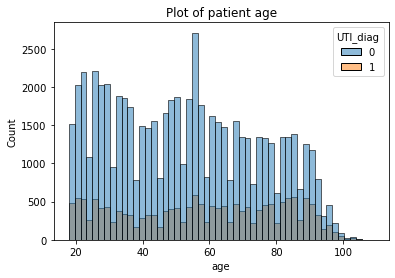

In [14]:
# Plot of patient age
ax = sns.histplot(x = 'age', hue='UTI_diag',data = dat)
ax.set_title('Plot of patient age')

Text(0.5, 1.0, 'Plot of patient gender')

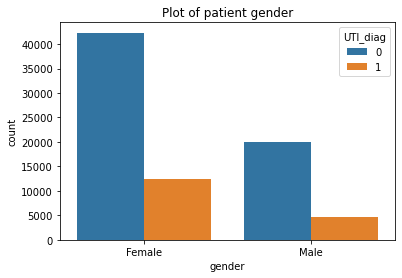

In [15]:
# Plot of patient gender
ax = sns.countplot(x = 'gender', hue='UTI_diag',data = dat)
ax.set_title('Plot of patient gender')

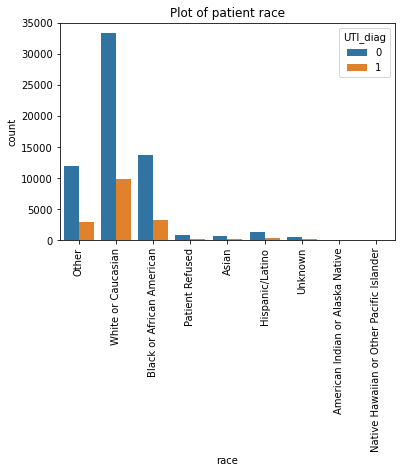

In [16]:
# Plot of patient race
ax = sns.countplot(x = 'race', hue='UTI_diag',data = dat)
ax.set_title('Plot of patient race')
plt.xticks(rotation=90);

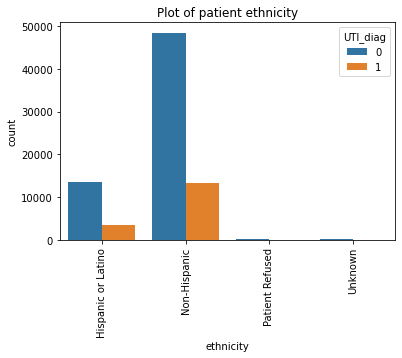

In [17]:
# Plot of patient ethnicity
ax = sns.countplot(x = 'ethnicity', hue='UTI_diag',data = dat)
ax.set_title('Plot of patient ethnicity')
plt.xticks(rotation=90);

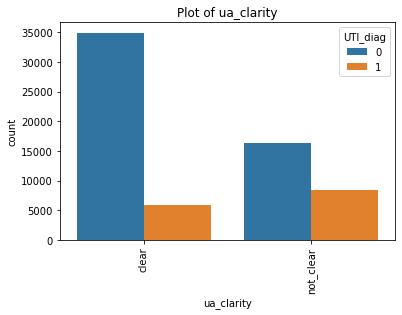

In [18]:
# Plot of ua_clarity
ax = sns.countplot(x = 'ua_clarity', hue='UTI_diag',data = dat)
ax.set_title('Plot of ua_clarity')
plt.xticks(rotation=90);

Text(0.5, 1.0, 'Plot of ua_color')

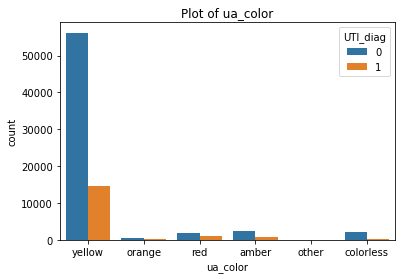

In [19]:
# Plot of ua_color
ax = sns.countplot(x = 'ua_color', hue='UTI_diag',data = dat)
ax.set_title('Plot of ua_color')

Text(0.5, 1.0, 'Plot of ua_color')

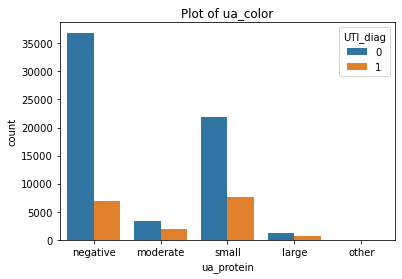

In [20]:
# Plot of ua_color
ax = sns.countplot(x = 'ua_protein', hue='UTI_diag',data = dat)
ax.set_title('Plot of ua_color')

Text(0.5, 1.0, 'Plot of ua_ph')

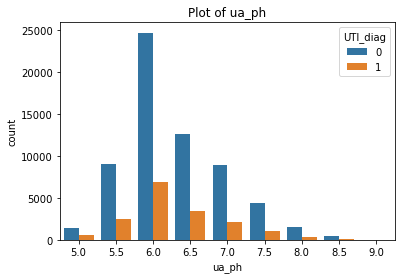

In [21]:
# Plot of ua_ph
ax = sns.countplot(x = 'ua_ph', hue='UTI_diag',data = dat)
ax.set_title('Plot of ua_ph')

In [29]:
# Impute -1 to missing value
print(-1 in dat.values)
dat.fillna(value=-1,inplace=True)

False


In [30]:
# Convert categorical variables
dat[categorical_features.columns] = dat[categorical_features.columns].astype(str)
dat[categorical_features.columns] = dat[categorical_features.columns].apply(LabelEncoder().fit_transform)

In [33]:
# Feature selection
# Use feature importance from random forest
X = dat.drop(columns=['UTI_diag','id','patid'])
y = dat['UTI_diag']

clf = RandomForestClassifier(n_estimators = 100, random_state=42).fit(X, y)
sel = SelectFromModel(clf,prefit=True)

In [34]:
# Get the number and list of selected features
selected_feat= X.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

85
Index(['ua_bacteria', 'ua_blood', 'ua_clarity', 'ua_epi', 'ua_leuk',
       'ua_nitrite', 'ua_ph', 'ua_protein', 'ua_rbc', 'ua_spec_grav',
       'ua_urobili', 'ua_wbc', 'abd_tenderness', 'fever', 'abd_pain',
       'dysuria', 'chief_complaint', 'age', 'race', 'maritalStatus',
       'employStatus', 'insurance_status', 'arrival', 'Temp_First',
       'Temp_Last', 'Temp_Max', 'Temp_Min', 'Temp_Mean', 'HR_First', 'HR_Last',
       'HR_Max', 'HR_Min', 'HR_Mean', 'SBP_First', 'SBP_Last', 'SBP_Max',
       'SBP_Min', 'SBP_Mean', 'DBP_First', 'DBP_Last', 'DBP_Max', 'DBP_Min',
       'DBP_Mean', 'RR_First', 'RR_Last', 'RR_Max', 'RR_Min', 'O2_Sat_First',
       'O2_Sat_Last', 'O2_Sat_Max', 'O2_Sat_Min', 'O2_Sat_Mean', 'GCS_First',
       'GCS_Last', 'Absolute_Lymphocyte_Count', 'Alanine_Aminotransferase',
       'Alkaline_Phosphatase', 'anc', 'Anion_Gap',
       'Aspartate_Aminotransferase', 'Basophils', 'bun', 'Calcium', 'Chloride',
       'co2', 'Creatinine', 'Eosinophils', 'Glucose', 'He

In [35]:
# Split into training, validation, and testing data (80%-10%-10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=1/9, random_state=42)

In [36]:
# Logistic regression
clf = LogisticRegression(max_iter=1000) 
clf.fit(X_train[selected_feat], y_train)

LogisticRegression(max_iter=1000)

C:\Users\Peng Shen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Logistic Regression AUC')

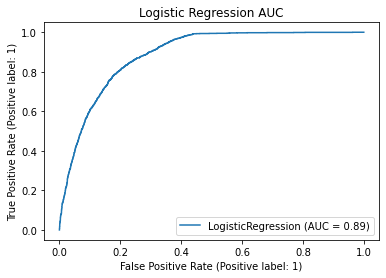

In [37]:
# AUC for logistic regression
plot_roc_curve(clf, X_test[selected_feat], y_test)
plt.title('Logistic Regression AUC')

Text(0.5, 1.0, 'Logistic Regression PR-AUC')

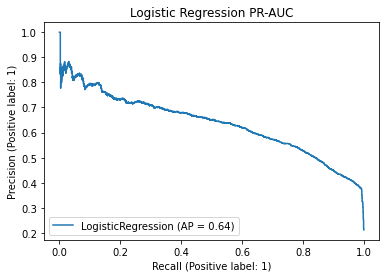

In [38]:
# PR AUC for logistic regression
PrecisionRecallDisplay.from_estimator(clf, X_test[selected_feat], y_test)
plt.title('Logistic Regression PR-AUC')

Text(0.5, 1.0, 'Logistic Regression Calibration Curve')

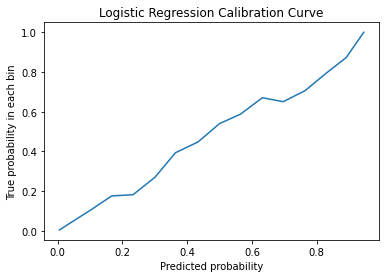

In [39]:
# Calibration curve for logistic regression
prob_true, prob_pred = calibration_curve(y_test, clf.predict_proba(X_test[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Logistic Regression Calibration Curve')

In [90]:
# Random Forest with hyperparameter tuning
# Create parameters dictionary
params = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 50],
    'min_samples_split': [5, 10, 50],
    'n_estimators': [100, 200, 400]}

rf = RandomForestClassifier(random_state = 42)
best_score = 0.8

# Grid search
for g in ParameterGrid(params):
    
    rf.set_params(**g)
    rf.fit(X_train[selected_feat], y_train)
    score = roc_auc_score(y_valid,rf.predict_proba(X_valid[selected_feat])[:,1])
    
    if score > best_score:
        best_score = score
        best_grid = g
        print("AUC:", best_score)
        print("Grid:", best_grid)

AUC: 0.8962261344096007
Grid: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
AUC: 0.8969531322908841
Grid: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
AUC: 0.8971662975313673
Grid: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 200}
AUC: 0.9156140997672461
Grid: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
AUC: 0.9166406562569587
Grid: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
AUC: 0.9247913392265622
Grid: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
AUC: 0.9258654351684762
Grid: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
AUC: 0.9259342726648611
Grid: {'bootstrap': True, 'max_de

In [40]:
# Random Forest
rf = RandomForestClassifier(random_state = 42, bootstrap=False, max_depth=20, min_samples_leaf=5, min_samples_split=5, 
                            n_estimators = 400)
rf.fit(X_train[selected_feat], y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=400, random_state=42)

C:\Users\Peng Shen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Random Forest AUC')

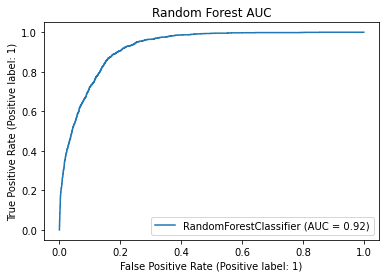

In [41]:
# AUC for Random Forest
plot_roc_curve(rf, X_test[selected_feat], y_test)
plt.title('Random Forest AUC')

Text(0.5, 1.0, 'Random Forest PR-AUC')

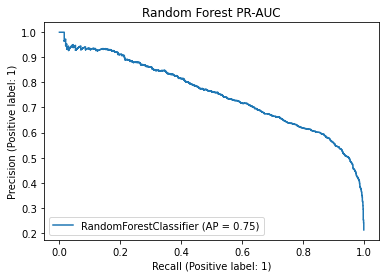

In [42]:
# PR AUC for Random Forest
PrecisionRecallDisplay.from_estimator(rf, X_test[selected_feat], y_test)
plt.title('Random Forest PR-AUC')

Text(0.5, 1.0, 'Random Forest Calibration Curve')

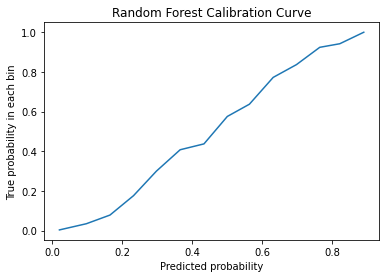

In [44]:
# Calibration curve for Random Forest
prob_true, prob_pred = calibration_curve(y_test, rf.predict_proba(X_test[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('Random Forest Calibration Curve')

In [50]:
# xgboost with hyperparameter tuning
# Create parameters dictionary
params = {
    'max_depth': [5, 10, 20],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'n_estimators': [100, 200, 400]}

model = XGBClassifier(random_state = 42)
best_score = 0.9

# Grid search
for g in ParameterGrid(params):
    
    model.set_params(**g)
    model.fit(X_train[selected_feat], y_train)
    score = roc_auc_score(y_valid,model.predict_proba(X_valid[selected_feat])[:,1])
    
    if score > best_score:
        best_score = score
        best_grid = g
        print("AUC:", best_score)
        print("Grid:", best_grid)

AUC: 0.9226729461247261
Grid: {'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
AUC: 0.9229376701880049
Grid: {'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
AUC: 0.9230988146090723
Grid: {'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}
AUC: 0.9231845611817504
Grid: {'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 0.1}
AUC: 0.9237642745405673
Grid: {'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1}
AUC: 0.9241270342866172
Grid: {'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 0.1}
AUC: 0.9241921758100418
Grid: {'max_depth': 10, 'n_estimators': 400, 'reg_alpha': 1, 'reg_lambda': 0.1}
AUC: 0.9244944601985292
Grid: {'max_depth': 10, 'n_estimators': 400, 'reg_alpha': 1, 'reg_lambda': 1}
AUC: 0.9247922170201404
Grid: {'max_depth': 20, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
AUC: 0.9248681692644735
Grid: {'max_depth': 20, 'n_estimators': 200, 'reg_

In [51]:
# xgboost
model = XGBClassifier(random_state = 42, max_depth=20, n_estimators=400, reg_alpha=0.1, reg_lambda=1)
model.fit(X_train[selected_feat], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

C:\Users\Peng Shen\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'xgboost AUC')

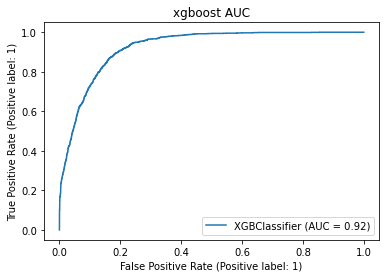

In [52]:
# AUC for xgboost
plot_roc_curve(model, X_test[selected_feat], y_test)
plt.title('xgboost AUC')

Text(0.5, 1.0, 'xgboost PR-AUC')

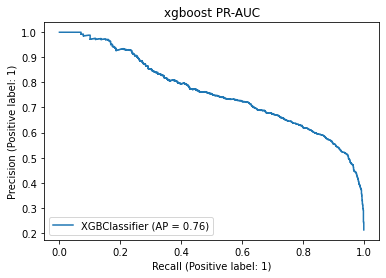

In [53]:
# PR AUC for Random Forest
PrecisionRecallDisplay.from_estimator(model, X_test[selected_feat], y_test)
plt.title('xgboost PR-AUC')

Text(0.5, 1.0, 'xgboost Calibration Curve')

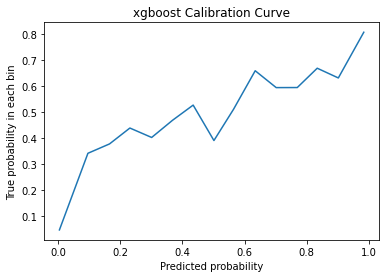

In [54]:
# Calibration curve for Random Forest
prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_test[selected_feat])[:,1], n_bins=15)
plt.plot(prob_pred,prob_true)
plt.xlabel('Predicted probability')
plt.ylabel('True probability in each bin')
plt.title('xgboost Calibration Curve')